<h1> Notebook Structure</h1> 

The objective is to build a model that is able to correctly identify a word as named entity. The classes to recognize are: 

    - geo = Geographical Entity
    - org = Organization
    - per = Person
    - gpe = Geopolitical Entity
    - tim = Time indicator
    - art = Artifact
    - eve = Event
    - nat = Natural Phenomenon

The dataset provided contains tokenized words and punctuation from a sequence of sentences, along with the tokens part-of-speech tag. Each token is labelled with the corresponding entity class or "O" for non-named entity elements.

- We will start by doing a quick exploration of the dataset, to get an idea of useful features and metrics to use.
- We then iteratively engineer new feature and build better models, using cross validation as a performance guide
- We conclude with a diagnostic of the best model

<h1> Exploratory analysis </h1>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pdb
%matplotlib inline

In [2]:
def base_dataset(filepath):
    """
    - read tab separated text file, expecting standard ascii characters
    - remove unnamed index column
    - collapse B-X and I-X classes into a single X class
    """
    
    data = pd.read_csv(filepath, sep="\t", encoding="latin-1")
    data.drop([x for x in data.columns if "Unnamed" in x], axis=1, inplace=True)
    data["Tag"] = [x[2:] if x!='O' else x for x in data["Tag"]]
    return data

data = base_dataset("dataset_22nov17.txt")
data.head(3)

,Sentence #,Word,POS,Tag
0,1.0,Thousands,NNS,O
1,1.0,of,IN,O
2,1.0,demonstrators,NNS,O


<h3> What kind of Part-of-Speech tag is associated with the target entity tags? </h3>

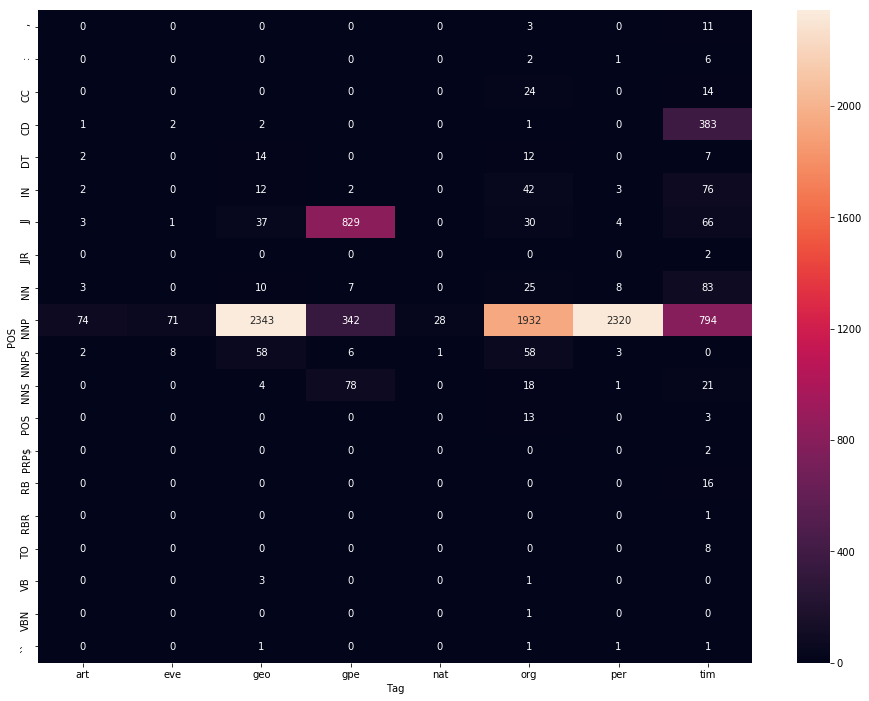

In [3]:
def crosstab(df):
    """
    - cross tabulation between the Part-of-Speech feature and the target entity tag
    - remove the "O" tag, and keep only POS which contain at least 1 occurence of non "O" tag
    """
    pos_tag = pd.crosstab(data["POS"], data["Tag"]).drop("O", axis=1)
    pos_tag = pos_tag.loc[~(pos_tag==0).all(axis=1)]
    plt.subplots(figsize=(16,12))
    sns.heatmap(pos_tag, annot=True, fmt="d")
    return

crosstab(data)

<h3> observations: </h3> 
- <b> The dataset is unbalanced.</b> Not only there are many less occurences of tagged entities than "O" words (as expected), but some tagged classes are much more frequent than others (geo vs natural phenomenon). <b> Accuracy metrics are thus insufficient, recall and precision ought to be used.</b> A high recall score indicates that the classifier is good at identifying True positives for each class, while a high precision indicates that it is good at minimizing the False positives.


- The NNP tag (singular proper noun) is most associated with the geo, org and per tags, so a classifier with this single feature will be a start. However it is a multiclass problem, which features could further differentiate the above classes?

<h3> Wordcloud for each sub classes</h3>

In [4]:
from wordcloud import WordCloud

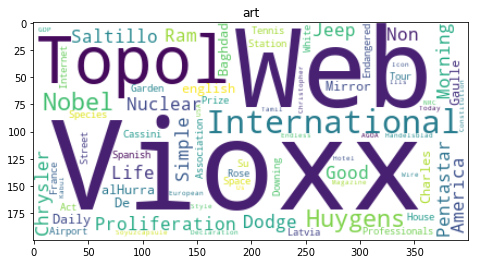

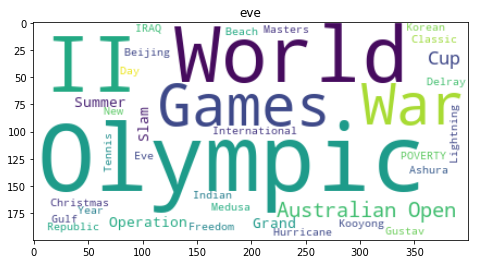

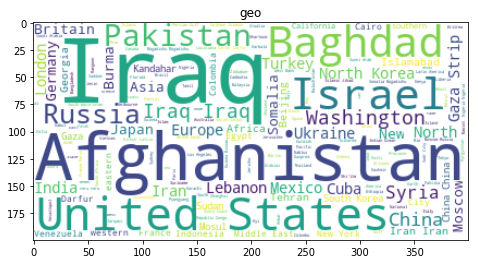

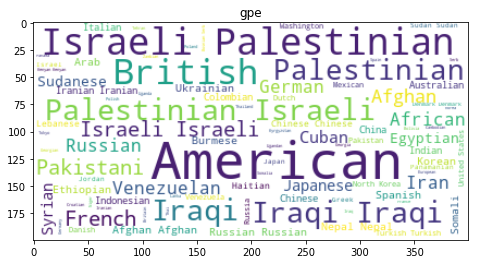

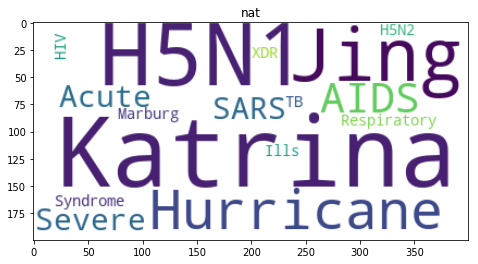

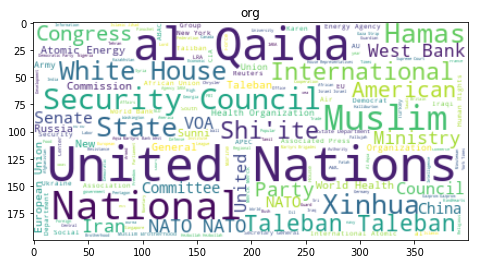

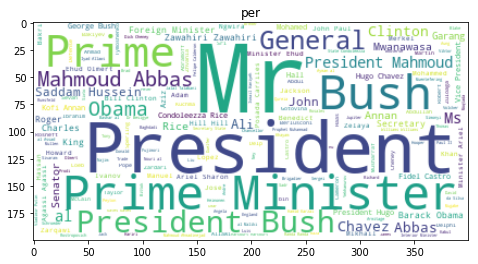

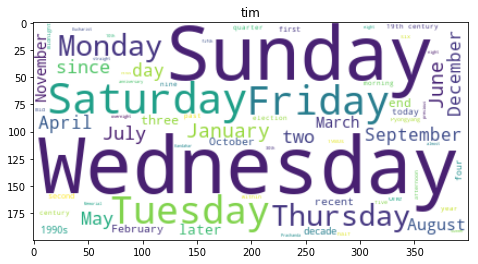

In [5]:
def class_corpus(df, classes):
    """
    - create a single string for a sub class
    - display a word cloud of the most frequent words in each class
    """
    
    plt.figure(figsize=(8,4))
    text = " ".join(df[df["Tag"]==item]["Word"])
    wordcloud = WordCloud(background_color='white', random_state=42).generate(text)
    plt.title(item)
    plt.imshow(wordcloud, interpolation='bilinear')
    return

for item in ["art", "eve", "geo", "gpe", "nat", "org", "per", "tim"]:
    class_corpus(data, item)

<h3> Observation </h3>

<b> Some target classes seem mainly composed of bi-grams or tri-grams.</b> For example in the category of Persons we find "President Bush", "Prime Minister", "Mahmoud Abbas". Other classes are made mainly of single tokens, such as the Geopolitical entities ("British, "American"). To separate between the various entity subclasses, a <b> classifier should thus consider the words preceding and following the considered token </b>

<h1> First iteration with scikit-learn random forest </h1>

We start by building the simplest model, using only the Part-of-Speech tag as feature. We use scikit-learn random forest classifier, which is a solid generic classification algorithm.

- Scikit-learn algorithms do not accept strings as input, so the feature is encoded as a list of integers. - Additionally, scikit-learn random forest requires that categorical features with several levels be transformed into multiple binary features (OneHotEncoding).
- Because entity classes are imbalanced, <b> the training and validation sets are split using a stratified shuffling </b>, so as to preserve a similar proportion of each classes in the training and validation sets.
- As a first protection against overfitting, a 5-fold cross validation is performed
- Finally two base metrics are tracked, the accuracy and the macro recall. The accuracy is the proportion of correctly predicted classes ([True Positive + True Negative] / [TP +FP + TN + FP]). The macro recall is the average of the recall for each sub classes (TP / [TP + FN]). The macro recall will be penalized if some classes have very poor recall (for example if the classifier fails to identify any True Positive within the more rare classes of the imbalanced dataset)

<b>Note:</b> The whole dataset is integer encoded before doing the train/validation split, as scikit-learn encoder does not accept unseen samples when using the .fit_transform method. This is not ideal for the real case where new words may appear in the test set that have not been encountered. Additionally, it may introduce some leakage, leading to overfitting and poorer generalization than expected. To be more rigorous one would encode only on the training set, apply the encoding on the validation set, and add another integer level, say -999, for unseen samples

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score

In [7]:
def score_model(df, metrics):
    """
    - encode string features and target into integers for sklearn
    - dummify categorical features
    - apply a simple random forest
    - score on a 5-stratified folds
    - output the predictions
    """

    le_features = LabelEncoder()
    le_target = LabelEncoder()
    features = le_features.fit_transform(data["POS"]).reshape(-1,1)  # reshape as a list of one element arrays for sklearn
    target = le_target.fit_transform(data["Tag"])
    
    cv = StratifiedKFold(n_splits=5, random_state=42)
    clf = Pipeline(steps=[('Encoding', OneHotEncoder()),
                          ('rf', RandomForestClassifier(random_state=42))])
    
    score = cross_val_score(clf, features, target, cv=cv, scoring=metrics)
    print("%s for each folds: %s" %(metrics, score))
    return

score_model(data, "accuracy")
score_model(data, "recall_macro")

accuracy for each folds: [ 0.88569054  0.88084624  0.88180169  0.8786184   0.87918651]
recall_macro for each folds: [ 0.22012121  0.2215954   0.21888262  0.21404418  0.21792315]


/home/gilles/.conda/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


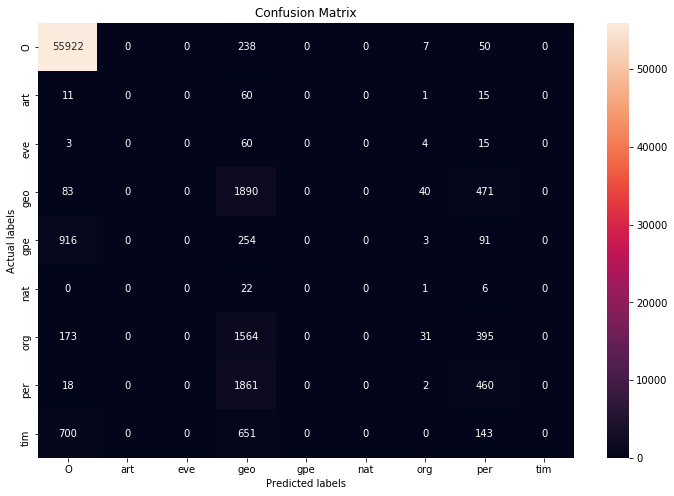

In [8]:
def predict_model(df):
    """
    - same pipeline as above but return predictions for each sample when it appears in the validation dataset
    - plot confusion matrix from those predictions
    """
    
    le_features = LabelEncoder()
    le_target = LabelEncoder()
    features = le_features.fit_transform(df["POS"]).reshape(-1,1)
    target = le_target.fit_transform(df["Tag"])
    mlabels = list(set(target))  # set of encoded labels to keep track of

    cv = StratifiedKFold(n_splits=5, random_state=42)
    clf = Pipeline(steps=[('Encoding', OneHotEncoder()),
                          ('rf', RandomForestClassifier(random_state=42))])
    
    preds = cross_val_predict(clf, features, target, cv=cv)
    conf_mat = metrics.confusion_matrix(target, preds, labels=mlabels)

    labels = le_target.inverse_transform(mlabels)  # retrieving initial value of the labels
    
    fig, ax = plt.subplots(1,1,figsize=(12,8))
    sns.heatmap(conf_mat, annot=True, fmt="d")
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('Actual labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    report = metrics.classification_report(target, preds, target_names=labels)
    return report

report = predict_model(data)

In [9]:
print(report)

             precision    recall  f1-score   support

          O       0.97      0.99      0.98     56217
        art       0.00      0.00      0.00        87
        eve       0.00      0.00      0.00        82
        geo       0.29      0.76      0.42      2484
        gpe       0.00      0.00      0.00      1264
        nat       0.00      0.00      0.00        29
        org       0.35      0.01      0.03      2163
        per       0.28      0.20      0.23      2341
        tim       0.00      0.00      0.00      1494

avg / total       0.85      0.88      0.86     66161



While the accuracy (percentage of correct classification) looks good, the metrics is misleading as expected. Looking at the recall and precision, we see that <b> for many sub classes the classifier fails to identify any positive sample (f1 is zero) </b>. Basically this classifier assigned the most frequent labels "geo" and "per" to the "NNP" Part-of-Speech tag

<h1> Adding features</h1>

Let's attempt to reduce the misclassification of "O" and increase the identification rate of the rarer sub classes <br>
The following binary features will be added:

    - Does the word start with an uppercase?
    - Is it the first word in a sentence?
    - Is it all capitalized?
    - Is it a digit?
    - what is the length of the word?
    - Same questions for the 2 words preceding and following it (if applicable)

In [10]:
def indexing_within_sentence(df):
    """
    word position index within the sentence
    """
    
    sentences_length = data.groupby("Sentence #", as_index=False)["Word"].count()
    df["word_index"] = [i for x in sentences_length["Word"] for i in range(x) ]
    return df


def shift_words(df):
    """
    get new columns with previous word and POS and following word and POS within each sentence
    """
    
    df[["previous_word", "previous_POS"]] = df[["Word", "POS"]].shift(1)
    # if the word was first in the sentence, there is no preceding word
    df.loc[df["word_index"]==0, ["previous_word", "previous_POS"]] = [".", "O"]
    
    df[["next_word", "next_POS", "next_index"]] = df[["Word", "POS", "word_index"]].shift(-1)
    # if the word was last in the sentence, there is no suceeding word
    df.loc[df.index==len(df)-1, ["next_word", "next_POS"]] = [".", "O"]
    df.loc[df["next_index"]==0, ["next_word", "next_POS"]] = [".", "O"]
    df.drop("next_index", axis=1, inplace=True)
    return df
    

def more_features(df):
    """ additional features """
    for item in ["Word", "previous_word", "next_word"]:
        df[item + "_is_uppercase"]= [1 if x[0].isupper() else 0 for x in df[item]]
        df[item + "_is_digit"] = [1 if x.isdigit() else 0 for x in df[item]]
        df[item + "_is_all_caps"] = [1 if x.isupper() else 0 for x in df[item]]
        df[item + "_length"] = [len(x) for x in df[item]]
    return df

In [11]:
data = indexing_within_sentence(data)
data = shift_words(data)
data = more_features(data)

In [12]:
def score_model(col_features, cat_features, df, metrics):

    features = df.copy()
    for item in cat_features:
        le_feature = LabelEncoder()
        features[item] = le_feature.fit_transform(df[item])
    features = features[col_features]
    le_target = LabelEncoder()
    target = le_target.fit_transform(df["Tag"])

    categoricals = [1 if item in cat_features else 0 for item in col_features]
    cv = StratifiedKFold(n_splits=5, random_state=42)
    clf = Pipeline(steps=[('Encoding', OneHotEncoder(categorical_features=categoricals)),
                          ('rf', RandomForestClassifier(random_state=42))])
    
    score = cross_val_score(clf, features, target, cv=cv, scoring=metrics)
    print("%s for each folds: %s" %(metrics, score))
    return

col_features = data.drop(["Sentence #", "Word", "Tag", "word_index", "previous_word", "next_word"], axis=1).columns
cat_features = ["POS", "previous_POS", "next_POS"]
score_model(col_features, cat_features, data, "accuracy")
score_model(col_features, cat_features, data, "recall_macro")

accuracy for each folds: [ 0.93585675  0.92988289  0.93493047  0.93250699  0.92734558]
recall_macro for each folds: [ 0.48766986  0.47529263  0.50167906  0.48056144  0.46623928]


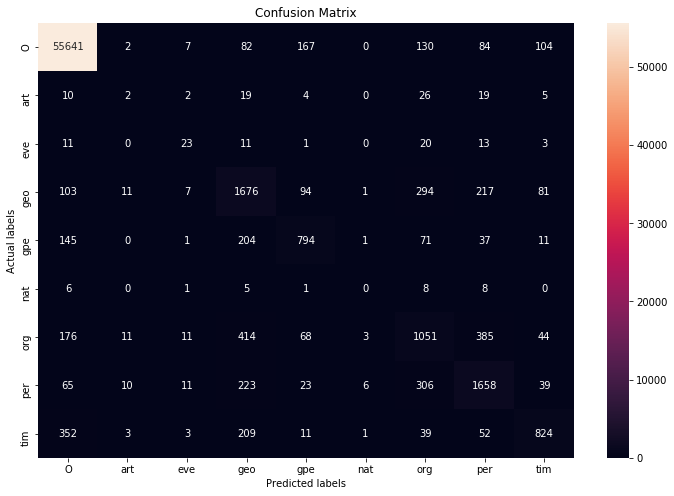

In [13]:
def predict_model(col_features, cat_features, df):
    
    features = df.copy()
    for item in cat_features:
        le_feature = LabelEncoder()
        features[item] = le_feature.fit_transform(df[item])
    features = features[col_features]
    le_target = LabelEncoder()
    target = le_target.fit_transform(df["Tag"])
    mlabels = list(set(target))
    
    categoricals = [1 if item in cat_features else 0 for item in col_features]
    cv = StratifiedKFold(n_splits=5, random_state=42)
    clf = Pipeline(steps=[('Encoding', OneHotEncoder(categorical_features=categoricals)),
                          ('rf', RandomForestClassifier(random_state=42))])
    
    preds = cross_val_predict(clf, features, target, cv=cv)
    conf_mat = metrics.confusion_matrix(target, preds, labels=mlabels)

    labels = le_target.inverse_transform(mlabels)  # retrieving initial value of the labels
    
    fig, ax = plt.subplots(1,1,figsize=(12,8))
    sns.heatmap(conf_mat, annot=True, fmt="d")
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('Actual labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    report = metrics.classification_report(target, preds, target_names=labels)
    return

report = predict_model(col_features, cat_features, data)

With just these features and without knowing the words themselves, we improved the accuracy, <b> doubled the recall, and are starting to populate the diagonal of the confusion matrix</b>. As expected this model is also better able to separate "O" tags from the other classes

<h1> Switching to a more powerful tree based method </h1>

One limitation with the previous algorithm is that for each categorical variable the dimensionality is vastly increased. While scikit-learn tree-based algorithms presuppose one-hot-encoding of the categorical variables, others like xgboost do not. The disadvantage of xgboost is that it requires more parameter tuning for good preformance

In [14]:
from xgboost.sklearn import XGBClassifier

/home/gilles/.conda/envs/kaggle/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
def score_model(col_features, cat_features, df, metrics):
    
    features = df.copy()
    for item in cat_features:
        le_feature = LabelEncoder()
        features[item] = le_feature.fit_transform(df[item])
    features = features[col_features]
    le_target = LabelEncoder()
    target = le_target.fit_transform(df["Tag"])
    
    cv = StratifiedKFold(n_splits=5, random_state=42)
    clf = Pipeline(steps=[('xgb', XGBClassifier(max_depth=4, learning_rate=0.2, seed=42))])
    score = cross_val_score(clf, features, target, cv=cv, scoring=metrics)
    print("%s for each folds: %s" %(metrics, score))
    return

In [16]:
def predict_model(col_features, cat_features, df):
    
    features = df.copy()
    for item in cat_features:
        le_feature = LabelEncoder()
        features[item] = le_feature.fit_transform(df[item])
    features = features[col_features]
    le_target = LabelEncoder()
    target = le_target.fit_transform(df["Tag"])
    mlabels = list(set(target))
    
    categoricals = [1 if item in cat_features else 0 for item in col_features]
    cv = StratifiedKFold(n_splits=5, random_state=42)
    clf = Pipeline(steps=[('xgb', XGBClassifier(max_depth=4, learning_rate=0.2, seed=42))])
    
    preds = cross_val_predict(clf, features, target, cv=cv)
    conf_mat = metrics.confusion_matrix(target, preds, labels=mlabels)

    labels = le_target.inverse_transform(mlabels)  # retrieving initial value of the labels
    
    fig, ax = plt.subplots(1,1,figsize=(12,8))
    sns.heatmap(conf_mat, annot=True, fmt="d")
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('Actual labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    report = metrics.classification_report(target, preds, target_names=labels)
    return report

In [17]:
col_features = data.drop(["Sentence #", "Word", "Tag", "previous_word", "next_word"], axis=1).columns
cat_features = ["POS", "previous_POS", "next_POS"]
score_model(col_features, cat_features, data, "accuracy")
score_model(col_features, cat_features, data, "recall_macro")

accuracy for each folds: [ 0.94069205  0.93282962  0.94022068  0.93621041  0.93437665]
recall_macro for each folds: [ 0.45699547  0.48231281  0.50072196  0.47118274  0.46601971]


<b> This is a slight improvement from the random forest. Let's now add the words themselves as feature. </b>

<h1> Adding the words themselves as a feature</h1>

In [18]:
col_features = data.drop(["Sentence #", "Tag"], axis=1).columns
cat_features = ["Word", "previous_word", "next_word", "POS", "previous_POS", "next_POS"]
score_model(col_features, cat_features, data, "accuracy")
score_model(col_features, cat_features, data, "recall_macro")

accuracy for each folds: [ 0.95111816  0.94280317  0.9495919   0.94921019  0.94617071]
recall_macro for each folds: [ 0.52471315  0.50369485  0.5526622   0.55244025  0.55672531]


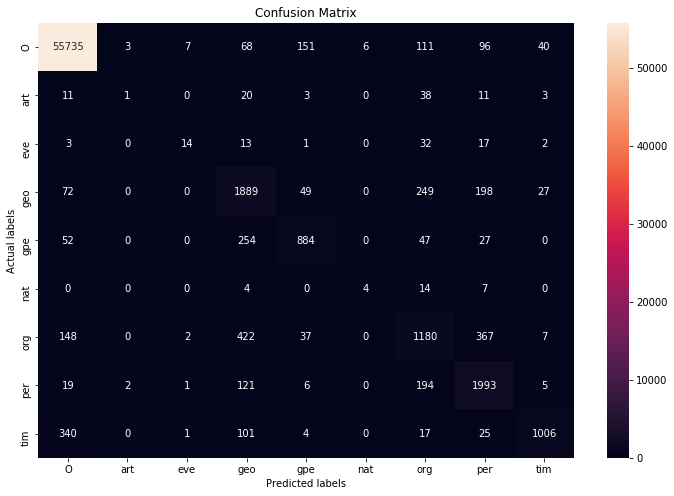

In [19]:
report = predict_model(col_features, cat_features, data)

In [20]:
print(report)

             precision    recall  f1-score   support

          O       0.99      0.99      0.99     56217
        art       0.17      0.01      0.02        87
        eve       0.56      0.17      0.26        82
        geo       0.65      0.76      0.70      2484
        gpe       0.78      0.70      0.74      1264
        nat       0.40      0.14      0.21        29
        org       0.63      0.55      0.58      2163
        per       0.73      0.85      0.78      2341
        tim       0.92      0.67      0.78      1494

avg / total       0.95      0.95      0.95     66161



Adding the words as features improved the model further. At this stage we have a basic classifier, which is decent for the most common subclasses, but <b> still very poor for rare named-entity classes</b>

<h1> Adding features from pretrained word vectors </h1>

Word embeddings is a technique that expresses a word as a real number vector of low dimension (typically 50-300 dimensions). The vector representation of a word is obtained by training a neural network on a large text corpus, as a result, words that are similar in meaning are also close to each others in the vector space. Let's use this characteristic to improve our classifier further.

We load a small pretrained word embedding (Glove, trained on wikipedia, with an english vocabulary of 400000 words), then apply the K-means clustering algorithm to identify clusters of word vectors. Each word in the dataset is then assigned a cluster, which provide us with an additional feature.

Another characteristic of word embedding is that one can do arithmetic on the word vectors. For example the summation of vector representation of ("king" + "woman" - "man" is equal to the vector representation of "queen"). 
Another way to add a feature is then to use the word vector to calculate the embedding of the bi-grams and tri-grams in the dataset as the sum of their component words embeddings. The resulting summed vectors themselves can be assigned to a kmean cluster

<b> We use the glove.6B.100d pretrained model </b>

In [21]:
from sklearn.cluster import MiniBatchKMeans  # using minibatch k0means for performance, some accuracy is lost

In [22]:
def load_word_vectors(filepath):
    """
    Load Glove's pretrained embedding into a dictionary {word: word vector}
    Build an numpy array of word vectors
    """
    
    embeddings = {}
    f = open(filepath, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings[word] = coefs
    f.close()
    
    emb_matrix = np.zeros((len(embeddings) + 1, 100))
    i = 0
    for word in embeddings:
        emb_matrix[i] = embeddings[word]
        i+=1
    return embeddings, emb_matrix

In [23]:
embeddings, emb_matrix = load_word_vectors("glove.6B.100d.txt")

In [24]:
def identify_clusters(emb_matrix):
    """
    Perform clustering for kmeans and dbscan
    """ 
    kmeans = MiniBatchKMeans(n_clusters=300, random_state=42).fit(emb_matrix)    # picking 300 clusters but should be tuned
    return kmeans

In [25]:
kmeans = identify_clusters(emb_matrix)

In [26]:
def assign_clusters(embeddings, kmeans, df):
    """
    - assign words within dataset to a cluster.
    - Words that do not exist in the pretrained embedding are assigned the null vector
    - calculate bigram vectors of (word, next word) and assign to clusters
    - calculate trigram vectors of (previous eword, word, next word) and assign to clusters
    """
    
    word_vector = []
    for word in df["Word"]:
        if word.lower() in embeddings:
            vector = embeddings[word.lower()]
        else:
            vector = np.zeros(100)
        word_vector.append(kmeans.predict(vector.reshape(1,-1))[0])
    df["word_vector"] = word_vector
    
    bigram_vector = []
    for word, next_word in zip(df["Word"], df["next_word"]):
        vector = np.zeros(100)
        for item in [word, next_word]:
            if item.lower() in embeddings:
                vector += embeddings[item.lower()]
            else:
                vector += np.zeros(100)
        bigram_vector.append(kmeans.predict(vector.reshape(1,-1))[0])
    df["bigram_vector"] = bigram_vector

    trigram_vector = []
    for word, next_word, previous_word in zip(df["Word"], df["next_word"], df["previous_word"]):
        vector = np.zeros(100)
        for item in [word, next_word, previous_word]:
            if item.lower() in embeddings:
                vector += embeddings[item.lower()]
            else:
                vector += np.zeros(100)
        trigram_vector.append(kmeans.predict(vector.reshape(1,-1))[0])
    df["trigram_vector"] = trigram_vector 

    return df

In [27]:
data = assign_clusters(embeddings, kmeans, data)

In [28]:
col_features = data.drop(["Sentence #", "Tag"], axis=1).columns
cat_features = ["Word", "previous_word", "next_word", "POS", "previous_POS", "next_POS"]
score_model(col_features, cat_features, data, "accuracy")
score_model(col_features, cat_features, data, "recall_macro")

accuracy for each folds: [ 0.9579178   0.94839441  0.95639359  0.95200665  0.94889242]
recall_macro for each folds: [ 0.56488056  0.53299553  0.5872383   0.6051065   0.56824462]


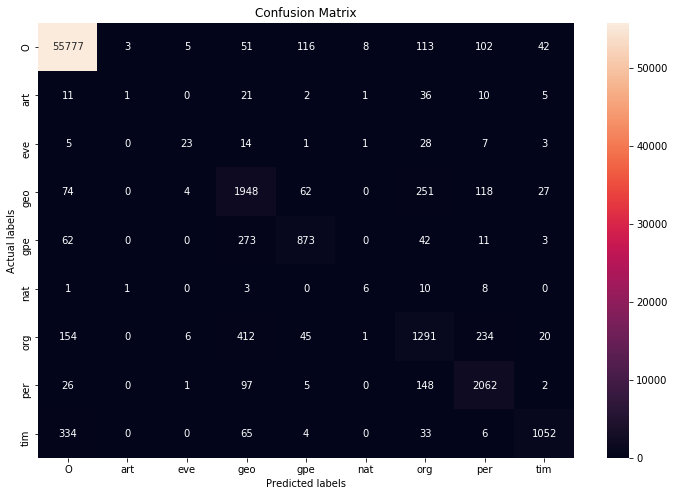

In [29]:
report = predict_model(col_features, cat_features, data)

In [30]:
print(report)

             precision    recall  f1-score   support

          O       0.99      0.99      0.99     56217
        art       0.20      0.01      0.02        87
        eve       0.59      0.28      0.38        82
        geo       0.68      0.78      0.73      2484
        gpe       0.79      0.69      0.74      1264
        nat       0.35      0.21      0.26        29
        org       0.66      0.60      0.63      2163
        per       0.81      0.88      0.84      2341
        tim       0.91      0.70      0.79      1494

avg / total       0.95      0.95      0.95     66161



<b>We got another boost from the word vector features, the average F1 score is 0.55</b>. At this stage let's pause and diagnose the model, with regard to whether it overfits or underfits, and how does the precision/recall curve look like, to suggest additional improvements.

<h1> Diagnostics </h1>

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

In [32]:
def learning_curve(df):
    """
    Plot the learning curve using the log-loss error on the training and validation set
    """
    
    features = df.copy()
    for item in cat_features:
        le_feature = LabelEncoder()
        features[item] = le_feature.fit_transform(df[item])
    features = features[col_features]
    le_target = LabelEncoder()
    target = le_target.fit_transform(df["Tag"])
    
    train_sizes=np.linspace(0.1, 0.9, 5)
    train_logloss = []
    val_logloss = []
    for train_size in train_sizes:
        X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=1-train_size,
                                                          stratify=target, random_state=42)
        
        eval_set = [(X_train, y_train), (X_val, y_val)]
        clf = XGBClassifier(max_depth=4, learning_rate=0.2, objective='multi:softprob', seed=42)
    
        clf.fit(X_train, y_train, eval_set=eval_set, eval_metric="mlogloss", verbose=False)
        
        results = clf.evals_result()
        train_logloss.append(results["validation_0"]["mlogloss"][-1])
        val_logloss.append(results["validation_1"]["mlogloss"][-1])
    plt.subplots(figsize=(16,6))
    plt.plot(train_sizes, train_logloss, 'r', label='training logloss')
    plt.plot(train_sizes, val_logloss, 'g', label='validation logloss')
    plt.xlabel('training size')
    plt.ylabel('log loss error')
    plt.title('Learning Curve')
    plt.legend()
    return

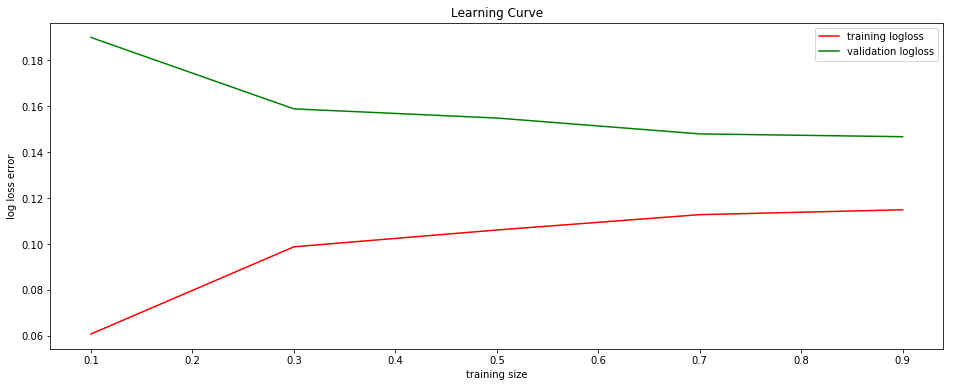

In [33]:
learning_curve(data)

This learning curve is somewhat typical.

<b> There is some overfitting based on the gap between the training error and the validation error </b> for large training size. This could be remediated in two main ways:
- <b> getting more data </b>
- <b> tuning the model by adding regularization parameters </b>

<b> The training error itself is still large </b>, and could be improved in a couple ways:
- <b> adding more engineered features </b>. The next couple cells will explore some possibilities
- <b> resampling to combat class imbalance </b>: removing samples from the majority classes, or augmenting the data for minority classes

<h3> Detailed look at the misclassification errors</h3>

One frequent classification error that accounts for a large percentage of the errors, as seen in the confusion matrix, is where the model predicts geographical entity ("geo") in lieu of the actual organisation entity ("org"). Let's look at some of these misclassifications.

In [34]:
def display_org_geo_misclassification(col_features, cat_features, df):
    """
    print the first 20 rows where the classifier misclassifies "org" for "geo"
    """
    features = df.copy()
    for item in cat_features:
        le_feature = LabelEncoder()
        features[item] = le_feature.fit_transform(df[item])
    features = features[col_features]
    le_target = LabelEncoder()
    target = le_target.fit_transform(df["Tag"])
    mlabels = list(set(target))
    
    categoricals = [1 if item in cat_features else 0 for item in col_features]
    cv = StratifiedKFold(n_splits=5, random_state=42)
    clf = Pipeline(steps=[('xgb', XGBClassifier(max_depth=4, learning_rate=0.2, seed=42))])
    
    preds = cross_val_predict(clf, features, target, cv=cv)
    conf_mat = metrics.confusion_matrix(target, preds, labels=mlabels)
    labels = le_target.inverse_transform(mlabels)
    
    misclass = pd.DataFrame(index= range(len(target)), columns=["preds", "actual"])
    misclass[["preds", "actual"]] = [(x[0], x[1]) for x in zip(preds, target)]
    error_index = misclass[(misclass["preds"]==3) & (misclass["actual"]==6)].index
    print(data.iloc[error_index][["previous_word", "Word", "next_word"]].head(20))
    return

In [35]:
display_org_geo_misclassification(col_features, cat_features, data)

     previous_word         Word  next_word
98           Labor        Party         in
359             by  Royal-Dutch      Shell
370            for        Shell          .
544             al        Qaida         in
546             in         Iraq   fighters
598             al        Qaida         in
600             in         Iraq   fighters
633             of        Sunni   militant
702            the  Brotherhood        off
963      depicting        Islam         's
1530            as         ABAC          .
1906       African        Union         in
2176             a      Vatican  spokesman
2289          many      Taliban  militants
2405           The         U.S.   military
2913        fallen     Islamist   movement
3242           for      Science        and
3541            of     American     States
3737       between        Hamas        and
3741         rival        Fatah      party


<b> Observations </b>
- The preposition "in" seems to trouble the classifier. When it is preceding or following the central word, it often misclassifies the entity as a geographical entity. Maybe dropping a set of some stopwords would help the classifier (this would have to be tested with cross-validation).


- Other simple features may improve classification, for example use the coma and period as a sequence delimiter, since often they indicate chunks of meaning and it is unlikely that the same type of classifier would be duplicated within one such chunk.


- <b> The main limitation of the used approach is that each sample is treated independently of the result of other samples within a sentence, paragraph or text sequence</b>. One could add features that add some sense of context in the current model, for example by adding summary counts of various "POS" within the sentence containing the word of interest. However to take full account of the information in the sequence of words in the sentence, different models such as <b> Long Short Term Memory models or Conditional Random Fields models.</b>

<h2> Classification using a conditional random field algorithm from python crfsuite library </h2>

In [36]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics as crfmetrics

In [37]:
def sentence_list(df):    
    sentences = []
    for i in pd.unique(df["Sentence #"]):
        sentences.append([(x[1], x[2], x[3]) for x in df[df["Sentence #"]==i][["Word", "POS", "Tag"]].itertuples()])
    return sentences

In [38]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'len(word)': len(word),
        'word[0].isupper()': word[0].isupper(),
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:len(word)': len(word1),
            '-1:word[0].isupper()': word1[0].isupper(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:len(word)': len(word1),
            '+1:word[0].isupper()': word1[0].isupper(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [39]:
def base_crf_model(df):
    """
    The CRF model considers the whole sentence context, so train/test split cannot be done the same way as with xgboost.
    Instead, the shuffling happens on the index of the sentences.
    """
    
    sentences_index = pd.unique(df["Sentence #"].astype(int))
    val_index = np.random.choice(sentences_index, int(0.2 * len(sentences_index)), replace=False)
    train_index = np.asarray([x for x in sentences_index if x not in val_index])

    train_sentences = sentence_list(df.loc[df["Sentence #"].isin(train_index)][["Sentence #", "Word", "POS", "Tag"]])
    val_sentences = sentence_list(df.loc[df["Sentence #"].isin(val_index)][["Sentence #", "Word", "POS", "Tag"]])
    
    X_train = [sent2features(s) for s in train_sentences]
    y_train = [sent2labels(s) for s in train_sentences]

    X_val = [sent2features(s) for s in val_sentences]
    y_val = [sent2labels(s) for s in val_sentences]

    crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True)
    crf.fit(X_train, y_train)
    preds = crf.predict(X_val)
    probas = crf.predict_marginals(X_val)
    labels = list(pd.unique(df["Tag"]))
    labels.remove("O")
    print(crfmetrics.flat_classification_report(y_val, preds, labels=labels, digits=3))
    return

base_crf_model(data)

             precision    recall  f1-score   support

        geo      0.732     0.833     0.779       485
        gpe      0.835     0.776     0.804       241
        per      0.860     0.879     0.870       547
        org      0.717     0.664     0.689       473
        tim      0.898     0.762     0.824       323
        art      0.250     0.059     0.095        17
        nat      0.000     0.000     0.000         6
        eve      0.750     0.188     0.300        16

avg / total      0.793     0.776     0.781      2108



/home/gilles/.conda/envs/kaggle/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<b> The crf model achieves an average F1 of 0.67, much better than the 0.55 of the xgboost model.</b>

One final way to obtain the last bit of performance for a classification task is then to ensemble the predictions from various well performing models, especially if the correlation between the models is low. The simplest way to ensemble models is simply averaging the predictions.

<h2> Ensemble predictions </h2>

In [40]:
def get_tag_index(df, tag):
    sample = df[df["Tag"]==tag][["Sentence #", "Tag"]]
    return pd.unique(sample["Sentence #"].astype(int))

def ensemble(col_features, cat_features, df):
    """
    Obtain prediction probabilities for each class with the crf and the boosted trees model
    Average the prediction probabilities
    """
    
    # stratified train/validation split
    indices = []
    for tag in ["art", "nat", "eve", "geo", "gpe", "per", "org", "tim"]:
        indices.append(get_tag_index(df, tag))
    to_include_in_val = []
    classes_index = []
    for index in indices:
        occurences = len(index)
        index = [x for x in index if x not in to_include_in_val]
        include = list(np.random.choice(index, int(0.2*occurences-(occurences-len(index))), replace=False))
        to_include_in_val += include
        classes_index += list([x for x in index if x not in classes_index])
    
    sentences_index = [x for x in pd.unique(df["Sentence #"].astype(int)) if x not in classes_index]
    val_index = np.random.choice(sentences_index, int(0.2 * len(sentences_index)), replace=False)
    train_index = np.asarray([x for x in sentences_index if x not in val_index])
    val_index = list(val_index) + to_include_in_val
    train_index = list(train_index) + [x for x in classes_index if x not in to_include_in_val]

    # data transformation for xgboost
    features = df.copy()
    for item in cat_features:
        le_feature = LabelEncoder()
        features[item] = le_feature.fit_transform(df[item])
    features = features[col_features]
    features["Sentence #"] = df["Sentence #"]
    le_target = LabelEncoder()
    ltarget = le_target.fit_transform(df["Tag"])
    target = pd.DataFrame(columns=["Tag", "Sentence #"])
    target["Tag"] = ltarget
    target["Sentence #"] = df["Sentence #"]

    # xgboost model
    X_train = features.loc[features["Sentence #"].isin(train_index)]
    y_train = target.loc[target["Sentence #"].isin(train_index)]
    X_val = features.loc[features["Sentence #"].isin(val_index)]
    y_val = target.loc[target["Sentence #"].isin(val_index)]
    
    clf = XGBClassifier(max_depth=4, learning_rate=0.2, objective='multi:softprob', seed=42)
    clf.fit(X_train.drop("Sentence #", axis=1), y_train.drop("Sentence #", axis=1).values.ravel(),
            eval_metric="mlogloss", verbose=False)
    xgb_preds = clf.predict_proba(X_val.drop("Sentence #", axis=1))
    labels = le_target.inverse_transform(clf.classes_)
    xgb_preds = pd.DataFrame(columns=labels, data=xgb_preds)
    
    # crf model
    train_sentences = sentence_list(df.loc[df["Sentence #"].isin(train_index)][["Sentence #", "Word", "POS", "Tag"]])
    val_sentences = sentence_list(df.loc[df["Sentence #"].isin(val_index)][["Sentence #", "Word", "POS", "Tag"]])
    X_train = [sent2features(s) for s in train_sentences]
    y_train = [sent2labels(s) for s in train_sentences]
    X_val = [sent2features(s) for s in val_sentences]
    
    crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True)
    crf.fit(X_train, y_train)
    crf_preds = crf.predict_marginals(X_val)
    preds = []
    for item in crf_preds:
        if item != []:
            for row in item:
                preds.append([row[tag] for tag in labels])
    crf_preds = pd.DataFrame(columns=labels, data=preds)
    
    ensemble_preds = (3*crf_preds + xgb_preds)/4.0
    y_val = y_val.drop("Sentence #", axis=1).values.ravel()
    y_val = [labels[x] for x in y_val]
    y_preds = [labels[np.argmax(ensemble_preds.iloc[i].values)] for i in range(len(ensemble_preds))]
    conf_mat = metrics.confusion_matrix(y_val, y_preds, labels=labels)

    fig, ax = plt.subplots(1,1,figsize=(12,8))
    sns.heatmap(conf_mat, annot=True, fmt="d")
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('Actual labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    report = metrics.classification_report(y_val, y_preds, target_names=labels)
    return report

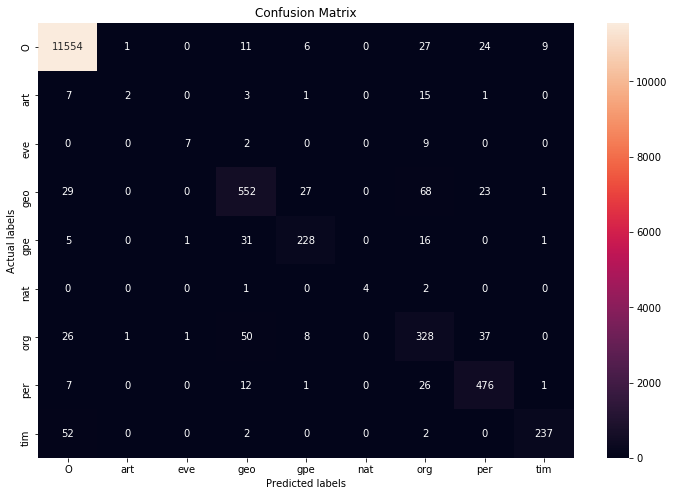

In [41]:
report = ensemble(col_features, cat_features, data)

In [42]:
print(report)

             precision    recall  f1-score   support

          O       0.99      0.99      0.99     11632
        art       0.50      0.07      0.12        29
        eve       0.78      0.39      0.52        18
        geo       0.83      0.79      0.81       700
        gpe       0.84      0.81      0.82       282
        nat       1.00      0.57      0.73         7
        org       0.67      0.73      0.69       451
        per       0.85      0.91      0.88       523
        tim       0.95      0.81      0.87       293

avg / total       0.96      0.96      0.96     13935



<b> The ensembling did provide a slight improvement (F1 ~ 0.67 - 0.70) </b>, although since this was run only on one subset of the dataset, it might just be a lucky fold.

<h1> Conclusions </b>

<b> A Named Entity Recognition classifier was build from combining a boosted tree model with a conditional random field model. The classifier achieves an F1 score of ~ 0.7.</b><br>

- A few additional features were proposed to improve the performance of the xgboost model on this dataset 


- There are only 2999 sentences and about 66000 words in the dataset, which is quite low. The learning curve suggest that the model also slightly overfits on this dataset, which may be remediated by adding more data.


- None of the component models have been tuned. Both models would benefit from hyperparameter tuning


- The classes are imbalanced. A few percent point of F1 score could be achieve by augmenting the number of samples containing the rarer classes.


- Like CFR models, LSTM models are able to take into account the context in which a particular sample is located. Beside they do not require adding hand-crafted features to the data. Adding such a model to the ensemble would enhance the precision and recall further.

With the above improvements, one could expect to reach a F1 score between 0.8 - 0.9